In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import math
import mlflow
import optuna
import os

from TMDP import TMDP
from algorithms import *
from model_functions import *
from policy_utils import *
from experiment_result_utils import *
from constants import *

from FrozenLake import *
from CurriculumPPO import CurriculumPPO

In [2]:
is_slippery = False
reward_shape = True
num_bins = 10
checkpoint_step=500
test_episodes = 1000
episodes = 2900000
num_runs = 10
dense_reward = True
shape_range=(-1,0)
goal_reward=1.
debug = False

In [3]:
#Frozen Lake Environment
nrows = 20
nS = nrows**2
nA = 4
gamma = 0.999
tau = 0.
xi = np.ones(nS) * 1/nS


In [4]:
run_name = f"PPO_{num_bins}"

mlflow.set_tracking_uri(MLFLOW_URI)
experiment_name = f"FrozenLake_{nrows}x{nrows}_{num_bins}"
experiment_id = get_or_create_experiment(experiment_name)
mlflow.set_experiment(experiment_name)

save_path = f"results/{experiment_name}/run_{run_name}"
label = run_name.split("_")[0]

In [5]:

model_lr = 0.25059450734174027
pol_lr = 0.2147313542957783
temp = 67.094199613244
epochs = 4
entropy_coef = 3.385445698551131
batch_size = 20
debug = False

final_temp=1
param_decay=True
lam = 1


eps_ppo = 0.2
eps_model = compute_eps_model(gamma, tau, episodes/10)

experiment_results = []
tests_rewards = []

In [6]:
def run_experiment(index, seed, run_name, change_map=False):
    sub_run_name = f"{run_name}_{index}"
    
    with mlflow.start_run(nested=True, run_name=sub_run_name):
        # Environment specific configuration   
        map_seed = seed if change_map else constants.SEEDS[0]
        set_policy_seed(seed)
        env = FrozenLakeEnv(is_slippery=False, seed=seed, 
                        desc=generate_random_map(nrows, seed=map_seed), 
                        reward_shape=True,
                        num_bins=num_bins,
                        dense_reward=dense_reward,
                        shape_range=shape_range,
                        goal_reward=goal_reward,
                        )
        
        # Environment independent configuration
        tmdp = TMDP(env, xi, tau=tau, gamma=gamma, seed=seed)
        tmdp.update_tau(tau)
        curr_PPO = CurriculumPPO(tmdp, checkpoint_step=checkpoint_step)

        curr_PPO.train(model_lr, pol_lr, batch_size=batch_size, 
                lam=lam, temp=temp, final_temp=final_temp,
                episodes=episodes, eps_ppo=eps_ppo,
                eps_model=eps_model,
                param_decay=param_decay, epochs=epochs, max_length=1000,
                entropy_coef=entropy_coef)
        
        avg_reward = np.average(curr_PPO.reward_records[-10:])/batch_size
        
        
        mlflow.log_metric("Avg Reward", avg_reward)
        
        run_dict = {
            "episodes": curr_PPO.episodes,
            "model_lr": model_lr,
            "pol_lr": pol_lr,
            "temp": temp,
            "final_temp": final_temp,
            "batch_size": batch_size,
            "epochs": epochs,
            "lam": lam,
            "eps_ppo": eps_ppo,
            "eps_model": eps_model,
        }
        mlflow.log_params(run_dict)
        mlflow.set_tags(tags={
            "run_name": run_name,
            "change_map": change_map,
            "seed": seed,
            "tau": nS,
            "gamma": gamma,
            "checkpoint_step": checkpoint_step,
            "test_episodes": test_episodes,
            "index": index,
            "dense_reward": dense_reward,
            "shape_range": shape_range,
            "goal_reward": goal_reward,
        })

        
        test_rewards = test_policies(tmdp, curr_PPO.thetas, test_episodes, 1e-5)
        
        result_dict = {
            "thetas" : curr_PPO.thetas,
            "taus" : curr_PPO.taus,
            "reward_records" : curr_PPO.reward_records,
            "test_rewards" : test_rewards,
            "index" : index,
        }

        tests_rewards.append(test_rewards)
        experiment_results.append(result_dict)
        # Save artifact to MLFlow
        try:
            save_to_mlflow(result_dict, run_name)
        except Exception as e:
            print(f"Error saving to MLFlow: {e}")
            print("Saving locally instead.")
            time.sleep(5)
            path = save_path+f"/{sub_run_name}"
            save(path, result_dict)

In [7]:
def run_experiments(change_map=False, num_runs=10):
    with mlflow.start_run(run_name=run_name):
        
        for i in range(num_runs):
            seed = constants.SEEDS[i]
            run_experiment(i, seed, run_name, change_map)
        
        experiment_dict = {
            "tests_rewards": tests_rewards,
            "num_runs": num_runs,
            "change_map": change_map,
            "num_bins": num_bins,
            "label": label,
        }
        try:
            save_to_mlflow(experiment_dict, run_name)
        except Exception as e:
            print(e)
            print("Something went wrong saving the experiment results to MLFlow.")
            print("Saving locally instead.")
            time.sleep(5)
            save(save_path, experiment_dict)

        rewards_fig = plot_avg_test_return(tests_rewards, f"PPO Avg Return on {num_runs} runs")
        try:
            mlflow.log_figure(figure=rewards_fig, artifact_file="reward_image.png")
        except Exception as e:
            print(e)
            print("Something went wrong saving the figure to MLFlow.")
            print("Saving locally instead.")
            time.sleep(5)
            rewards_fig.savefig(save_path+"/reward_image.png")

Current seed for result reproducibility: 2999
Episode: 5000 reward: -7988.6 length: 23
Episode: 10000 reward: -7999.5999999999985 length: 5
Episode: 15000 reward: -7988.199999999997 length: 60
Episode: 20000 reward: -7853.399999999996 length: 94
Episode: 25000 reward: -7927.299999999999 length: 7
Episode: 30000 reward: -7445.6999999999925 length: 20
Episode: 35000 reward: -7607.499999999994 length: 169
Episode: 40000 reward: -7571.89999999999 length: 177
Episode: 45000 reward: -7448.699999999994 length: 98
Episode: 50000 reward: -7384.099999999997 length: 87
Episode: 55000 reward: -7310.0999999999885 length: 102
Episode: 60000 reward: -7396.899999999998 length: 39
Episode: 65000 reward: -7250.599999999986 length: 16
Episode: 70000 reward: -7048.199999999994 length: 192
Episode: 75000 reward: -7060.399999999993 length: 137
Episode: 80000 reward: -6922.399999999989 length: 54
Episode: 85000 reward: -6865.29999999999 length: 146
Episode: 90000 reward: -6743.499999999992 length: 81
Episode

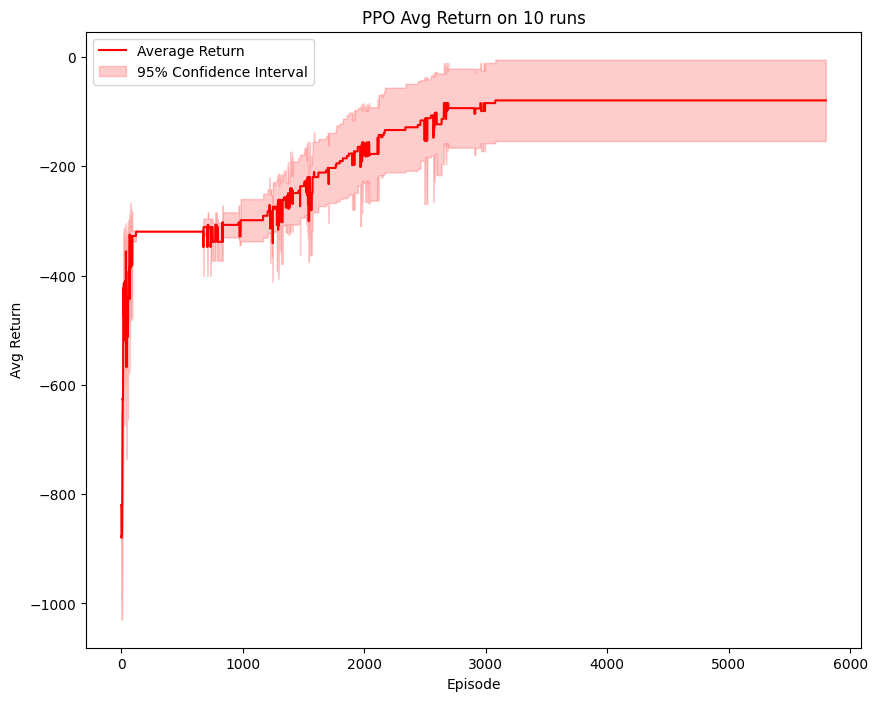

In [8]:
run_experiments(change_map=False, num_runs=num_runs)